In [26]:
import os
from glob import glob
import tifffile as tif
import numpy as np 
import matplotlib.pyplot as plt

In [27]:
base_path="D:/Ashish_GWL/Full_Dataset/DATA4/"
year_path=glob(base_path+"*")
row,col,factor,month=44,64,4,6

In [28]:
def factor_preprocessing(year):
    k=0
    factor=np.empty([row,col,4,month])
    img_names=glob(year+"/PrePost/GRACE/*.tif")
    
    for img_name in img_names:
        img_name=os.path.split(img_name)[-1]
        #print(img_name)
        grace_img=data_filtering(np.array(tif.imread(year+"/PrePost/Grace/"+img_name)),-200,200,210)
        rainfall=data_filtering(np.array(tif.imread(year+"/PrePost/Rainfall/"+img_name)),0,250,260)
        soil_moisture=data_filtering(np.array(tif.imread(year+"/PrePost/SM/"+img_name)),0,200,210)
        ET=data_filtering(np.array(tif.imread(year+"/PrePost/ET/"+img_name)),0,200,210)
        #run_off=data_filtering(np.array(tif.imread(year+"/PrePost/Runoff/"+img_name)),0,200,210)
        #print("Grace",grace_img.max(),grace_img.min())
        #print("rainfall", rainfall.max(),rainfall.min())
        factor[:,:,0,k]=grace_img[:row,:col]
        factor[:,:,1,k]=rainfall[:row,:col]
        factor[:,:,2,k]=soil_moisture[:row,:col]
        factor[:,:,3,k]=ET[:row,:col]
        #factor[:,:,4,k]=run_off[:row,:col]
        k=k+1
        #print(factor[:,:,0,k].max(),factor[:,:,0,k].min())
    return factor         
def data_filtering(img,low,high,value):
    temp=img
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i,j]>low and img[i,j]<high):
                temp[i,j]=img[i,j]
            else:
                temp[i,j]=value
    return temp/value
    #return (temp-temp.min()/temp.max()-temp.min())
    

In [29]:
yr=0
data_set=np.empty([12,44,64,4,6]) # (12 is years, size of image , 4 is factor, 6 is month cycle )
for year in year_path:
    montly=factor_preprocessing(year)
    print(year)
    data_set[yr]=montly
    yr=yr+1
print("Image sequence complete !!!!!")

D:/Ashish_GWL/Full_Dataset/DATA4\2005
D:/Ashish_GWL/Full_Dataset/DATA4\2006
D:/Ashish_GWL/Full_Dataset/DATA4\2007
D:/Ashish_GWL/Full_Dataset/DATA4\2008
D:/Ashish_GWL/Full_Dataset/DATA4\2009
D:/Ashish_GWL/Full_Dataset/DATA4\2010
D:/Ashish_GWL/Full_Dataset/DATA4\2011
D:/Ashish_GWL/Full_Dataset/DATA4\2012
D:/Ashish_GWL/Full_Dataset/DATA4\2013
D:/Ashish_GWL/Full_Dataset/DATA4\2014
D:/Ashish_GWL/Full_Dataset/DATA4\2015
D:/Ashish_GWL/Full_Dataset/DATA4\2016
Image sequence complete !!!!!


Image lable (End-result)

In [30]:
label_year=glob(base_path+"*")
label_arr=np.empty([12,row,col])
s=0
for year in label_year:
    print(year)
    PoPr=data_filtering(np.array(tif.imread(year+"/PrePost/PrePost*.tif")),-1500,1500,1550)
    label_arr[s,]=PoPr[:row,:col]
    s=s+1
    

D:/Ashish_GWL/Full_Dataset/DATA4\2005
D:/Ashish_GWL/Full_Dataset/DATA4\2006
D:/Ashish_GWL/Full_Dataset/DATA4\2007
D:/Ashish_GWL/Full_Dataset/DATA4\2008
D:/Ashish_GWL/Full_Dataset/DATA4\2009
D:/Ashish_GWL/Full_Dataset/DATA4\2010
D:/Ashish_GWL/Full_Dataset/DATA4\2011
D:/Ashish_GWL/Full_Dataset/DATA4\2012
D:/Ashish_GWL/Full_Dataset/DATA4\2013
D:/Ashish_GWL/Full_Dataset/DATA4\2014
D:/Ashish_GWL/Full_Dataset/DATA4\2015
D:/Ashish_GWL/Full_Dataset/DATA4\2016


In [31]:
print(label_arr.shape)

(12, 44, 64)


In [32]:
#initialize wandb and download dataset
epoch=10
batch_size=32
height=row
width=col
data=data_set.reshape([12,row,col, 4*6])
label=np.expand_dims(label_arr[:row,:col],axis=3)
train_x=data[:9]
test_x=data[9:]
train_y=label[:9]
test_y=label[9:]
print(train_x.shape)

(9, 44, 64, 24)


In [61]:
# Conv2DLSTM 
from tensorflow import keras as keras
from keras.layers import Lambda, Reshape, Permute, Input, add, Conv3D, GaussianNoise, concatenate,Conv2D
from keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Add,MaxPooling2D,UpSampling2D
from keras.models import Model

c=20

inp = Input((height, width, 4 * 6))
reshaped = Reshape((row,col,4,6))(inp)
permuted = Permute((4,1,2,3))(reshaped)
x =(ConvLSTM2D(filters=c, kernel_size=(3,3),padding='same',name='conv_lstm1', return_sequences=True))(permuted)

c1=(BatchNormalization())(x)
#x = Dropout(0.2)(x)
x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c1)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm3',return_sequences=True))(x)
c2=(BatchNormalization())(x)
#x = Dropout(0.2)(x)

x =(TimeDistributed(MaxPooling2D(pool_size=(2,2))))(c2)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm4',return_sequences=True))(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x =(ConvLSTM2D(filters=4*c,kernel_size=(3,3),padding='same',name='conv_lstm5',return_sequences=True))(x)
x =(BatchNormalization())(x)

x =(ConvLSTM2D(filters=2*c,kernel_size=(3,3),padding='same',name='conv_lstm6',return_sequences=True))(x)
x =(BatchNormalization())(x)
x = concatenate([c2, x])
#x = Dropout(0.2)(x)

x =(TimeDistributed(UpSampling2D(size=(2, 2))))(x)
x = concatenate([c1, x])
x =(ConvLSTM2D(filters=c,kernel_size=(3,3),padding='same',name='conv_lstm7',return_sequences=False))(x)
x =(BatchNormalization())(x)
output = Conv2D(1, (1,1))(x)
model=Model(inputs=[inp], outputs=[output])
#model.summary()
model.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.MeanAbsoluteError()])
          #    metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [62]:
model.fit(train_x,train_y,epochs=100, batch_size=2,verbose=1)

Epoch 1/100
9/9 [==============================] - 7s 760ms/step - loss: 3.3352 - mean_absolute_error: 1.5386
Epoch 2/100
9/9 [==============================] - 1s 67ms/step - loss: 0.4418 - mean_absolute_error: 1.0512
Epoch 3/100
9/9 [==============================] - 1s 68ms/step - loss: 0.2854 - mean_absolute_error: 0.8259
Epoch 4/100
9/9 [==============================] - 1s 68ms/step - loss: 0.1954 - mean_absolute_error: 0.7068
Epoch 5/100
9/9 [==============================] - 1s 66ms/step - loss: 0.1422 - mean_absolute_error: 0.6278
Epoch 6/100
9/9 [==============================] - 1s 69ms/step - loss: 0.1075 - mean_absolute_error: 0.5699
Epoch 7/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0819 - mean_absolute_error: 0.5229
Epoch 8/100
9/9 [==============================] - 1s 68ms/step - loss: 0.0617 - mean_absolute_error: 0.4840
Epoch 9/100
9/9 [==============================] - 1s 67ms/step - loss: 0.0469 - mean_absolute_error: 0.4505
Epoch 10/100
9/9 [

9/9 [==============================] - 1s 69ms/step - loss: 0.0027 - mean_absolute_error: 0.0987
Epoch 76/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0027 - mean_absolute_error: 0.0979
Epoch 77/100
9/9 [==============================] - 1s 70ms/step - loss: 0.0026 - mean_absolute_error: 0.0971
Epoch 78/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0026 - mean_absolute_error: 0.0963
Epoch 79/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0026 - mean_absolute_error: 0.0956
Epoch 80/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0026 - mean_absolute_error: 0.0948
Epoch 81/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0025 - mean_absolute_error: 0.0941
Epoch 82/100
9/9 [==============================] - 1s 70ms/step - loss: 0.0025 - mean_absolute_error: 0.0934
Epoch 83/100
9/9 [==============================] - 1s 70ms/step - loss: 0.0024 - mean_absolute_error: 0.0927
Epoch 84/100
9/9 [=====

Make Prediction

In [63]:
test=np.expand_dims(test_x[1],axis=0)

pred=model.predict(test)

In [64]:
results = model.evaluate(test_x, test_y)
print(results)

3/3 [==============================] - 2s 544ms/step
[0.018023641780018806, 0.08260920643806458]


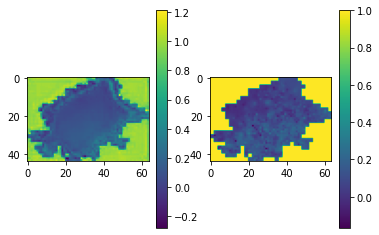

In [65]:
pred_show=np.squeeze(pred,axis=0)

plt.subplot(1,2,1)
plt.imshow(pred_show)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(train_y[0])
plt.colorbar()


In [ ]:
print(train_y[0].shape)
plt.hist(train[])